# Converting SMPL model to keypoints and save as videos

In [306]:
# This script is used to convert SMPL keypoint to 3D Motorica keypoint format
from pathlib import Path
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import cv2
import smplx
import torch
from tqdm import tqdm
# height of the skeleton
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial.transform import Rotation as R
# interactive plt
%matplotlib ipympl

sys.path.append("../")
from smpl2motorica.utils.bvh import BVHParser
from smpl2motorica.utils.pymo.preprocessing import MocapParameterizer

In [307]:
def get_SMPL_skeleton_names():
    return [
        "pelvis",
        "left_hip",
        "right_hip",
        "spine1",
        "left_knee",
        "right_knee",
        "spine2",
        "left_ankle",
        "right_ankle",
        "spine3",
        "left_foot",
        "right_foot",
        "neck",
        "left_collar",
        "right_collar",
        "head",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hand",
        "right_hand",
    ]


def get_motorica_skeleton_names():
    return [
        "Head",
        "Hips",
        "LeftArm",
        "LeftFoot",
        "LeftForeArm",
        "LeftHand",
        "LeftLeg",
        "LeftShoulder",
        # "LeftToeBase",
        "LeftUpLeg",
        "Neck",
        "RightArm",
        "RightFoot",
        "RightForeArm",
        "RightHand",
        "RightLeg",
        "RightShoulder",
        # "RightToeBase",
        "RightUpLeg",
        "Spine",
        "Spine1",
    ]
def smpl2motorica():
    return [
        "head",
        "pelvis",
        "left_shoulder",
        "left_ankle",
        "left_elbow",
        "left_wrist",
        "left_knee",
        "left_collar",
        "left_hip",
        "neck",
        "right_shoulder",
        "right_ankle",
        "right_elbow",
        "right_wrist",
        "right_knee",
        "right_collar",
        "right_hip",
        "spine2",
        "spine3"
    ]
# def smpl2motorica():
#     return [
#         "head",
#         "pelvis",
#         "right_shoulder",
#         "right_ankle",
#         "right_elbow",
#         "right_wrist",
#         "right_knee",
#         "right_collar",
#         "right_hip",
#         "neck",
#         "right_shoulder",
#         "right_ankle",
#         "right_elbow",
#         "right_wrist",
#         "right_knee",
#         "right_collar",
#         "right_hip",
#         "spine2",
#         "spine3"
#     ]
# append x, y, z rotation to each joint
def expand_skeleton(skeleton: list):
    expanded_skeleton = [f"{joint}_{axis}rotation" for joint in skeleton for axis in ['X', 'Y', 'Z']]
    return expanded_skeleton

def motorica_draw_stickfigure3d(
    fig,
    mocap_track,
    frame,
    data=None,
    joints=None,
    draw_names=True,
):
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0, azim=120)

    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints

    if data is None:
        df = mocap_track.values
    else:
        df = data

    for idx, joint in enumerate(joints_to_draw):
        # ^ In mocaps, Y is the up-right axis
        parent_x = df["%s_Xposition" % joint][frame]
        parent_y = df["%s_Zposition" % joint][frame]
        parent_z = df["%s_Yposition" % joint][frame]

        # parent_x = df["%s_Xposition" % joint][frame]
        # parent_y = df["%s_Yposition" % joint][frame]
        # parent_z = df["%s_Zposition" % joint][frame]

        ax.scatter(xs=parent_x, ys=parent_y, zs=parent_z, alpha=0.6, c="b", marker="o")
        

        children_to_draw = [
            c for c in mocap_track.skeleton[joint]["children"] if c in joints_to_draw
        ]

        for c in children_to_draw:
            # ^ In mocaps, Y is the up-right axis
            child_x = df["%s_Xposition" % c][frame]
            child_y = df["%s_Zposition" % c][frame]
            child_z = df["%s_Yposition" % c][frame]

            ax.plot(
                [parent_x, child_x],
                [parent_y, child_y],
                [parent_z, child_z],
                # "k-",
                lw=2,
                c="black",
            )

        if draw_names:
            ax.text(
                x=parent_x - 0.01,
                y=parent_y - 0.01,
                z=parent_z -0.01,
                s=f"{idx}:{joint}",
                fontsize=5,
            )

    return ax


def SMPL_output_video(joints, vertices, model):
    for i in tqdm(range(joints.shape[0]), desc="Generating SMPL video"):
        fig = plt.figure(figsize=(10, 10))
        ax = SMPL_visulize_a_frame(fig, joints[i], vertices[i], model)
        ax.set_title(f"SMPL frame {i}")
        plt.savefig(f"smpl_frame_{i:04d}.png")
        plt.close(fig)
    
    # compile the video
    image_folder = '.'
    video_name = 'smpl_video.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 6 # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    # remove the images
    for image in images:
        os.remove(os.path.join(image_folder, image))
    
    return video_name

def SMPL_visulize_a_frame(fig, joints, vertices, model, output_name="test.png"):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0)
    mesh = Poly3DCollection(vertices[model.faces], alpha=0.01)
    face_color = (1.0, 1.0, 0.9)
    edge_color = (0, 0, 0)
    mesh.set_edgecolor(edge_color)
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color="r")
    # ax.set_xlim([-1, 1])
    # ax.set_ylim([-1, 1])
    # ax.set_zlim([-1, 1])
    joint_names = get_SMPL_skeleton_names()
    for i, joint in enumerate(joints):
        ax.text(
            joint[0],
            joint[1],
            joint[2],
            f"{i}:{joint_names[i]}",
            color="blue",
            fontsize=5,
        )
    ax.view_init(elev=0, azim=180)
    return ax


## Load Dummy Motorica data

In [308]:
motorica_data_root = Path("./data/motorica_dance_dataset")
motorica_motion_path = (
    motorica_data_root
    / "bvh"
    / "kthjazz_gCH_sFM_cAll_d02_mCH_ch01_beatlestreetwashboardbandfortyandtight_003.bvh"
)
if not motorica_motion_path.exists():
    raise FileNotFoundError(f"Motion file {motorica_motion_path} does not exist. ")
bvh_parser = BVHParser()
motorica_dummy_data = bvh_parser.parse(motorica_motion_path)

# # Filter out unnecessary columns
# joints_to_keep = get_motorica_skeleton_names()
# expand_joints_to_keep = expand_skeleton(joints_to_keep)
# # append location to the joint names
# expand_joint_with_location = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition'] + expand_joints_to_keep
# # filter out unnecessary joints

In [309]:
# skeleton_list = sorted(list(motorica_dummy_data.skeleton.keys()))
# skeleton_list

In [310]:
# scale the skeleton
def skeleton_scaler(skeleton, ratio):
    for joint in skeleton:
        skeleton[joint]["offsets"] = np.array(skeleton[joint]["offsets"]) * ratio
    return skeleton

ratio = 0.01
motorica_dummy_data.skeleton = skeleton_scaler(motorica_dummy_data.skeleton, ratio)


## Loading SMPL model from the aist dataset

In [311]:
dataset_fps = 60
target_fps = 6
aist_data_root = Path("./data/AIST++/")
smpl_model_path = Path("./smpl/models")

if not aist_data_root.exists():
    print(f"Please download AIST++ dataset to {aist_data_root}")
    sys.exit(1)
if not smpl_model_path.exists():
    print(f"Please download SMPL model to {smpl_model_path}")
    sys.exit(1)

# load all aist data *.pkl files
aist_file_list = list(aist_data_root.glob("*.pkl"))
print(f"Found {len(aist_file_list)} AIST++ data files")

data_file = aist_file_list[0]
print(f"Processing {data_file}")
data = np.load(data_file, allow_pickle=True)

# sample to target fps
sample_indices = np.arange(0, len(data["smpl_poses"]), dataset_fps // target_fps)

# extract pose, root translation ans scale
poses = data["smpl_poses"][sample_indices]
root_trans = data["smpl_trans"][sample_indices]
scales = data["smpl_scaling"]

smpl_model = smplx.create(
    model_path=smpl_model_path,
    model_type="smpl",
    return_verts=True,
    batch_size=len(poses),
)

# seperate the root rotation and body pose
smpl_body_pose = poses[:, 3:]
smpl_root_rot = poses[:, :3]
# reset the starting root position to origin
root_trans -= root_trans[0]




Found 6 AIST++ data files
Processing data\AIST++\gBR_sBM_cAll_d04_mBR0_ch01.pkl


Rotate the SMPL pose to Motorica pose

In [312]:
# Rotate root trans by 90 degree around y axis and then 90 degree around x axis
# Convert root rotation to quaternion
smpl_root_rot_quat = R.from_euler('xyz', smpl_root_rot, degrees=False).as_quat()
# rot_x = R.from_euler('x', np.pi/2, degrees=False).as_quat()
# rot_z = R.from_euler('y', 0, degrees=False).as_quat()
# rot_offset = R.from_quat(rot_z)* R.from_quat(rot_x) 
rot_offset = R.from_euler('xyz', [np.pi/2, 0, 0], degrees=False)
smpl_root_rot_quat = rot_offset * R.from_quat(smpl_root_rot_quat)
rotated_smpl_root_rot = smpl_root_rot_quat.as_euler('xyz', degrees=False) 

Forward kinematics

In [313]:
smpl_output = smpl_model(
    body_pose=torch.tensor(smpl_body_pose, dtype=torch.float32),
    # transl=torch.tensor(root_trans, dtype=torch.float32),
    global_orient=torch.tensor(smpl_root_rot, dtype=torch.float32), 
)
# get the joints loc
smpl_joints_loc = smpl_output.joints.detach().cpu().numpy().squeeze()
# get the SMPL joints (first 24 joints)
smpl_joints = smpl_joints_loc[:, :24, :]

Setting the pelvis to the origin

In [314]:

# get the location of pelvis
pelvis_loc = smpl_joints_loc[:, 0, :]
# apply the offset to the global location so that the pelvis is at the origin
smpl_output = smpl_model(
    body_pose=torch.tensor(smpl_body_pose, dtype=torch.float32),
    global_orient=torch.tensor(rotated_smpl_root_rot, dtype=torch.float32), 
    transl=torch.tensor(-pelvis_loc, dtype=torch.float32),
)
smpl_joints_loc = smpl_output.joints.detach().cpu().numpy().squeeze()
smpl_vertices = smpl_output.vertices.detach().cpu().numpy().squeeze()
smpl_joints = smpl_joints_loc[:, :24, :]


<Axes3D: xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>

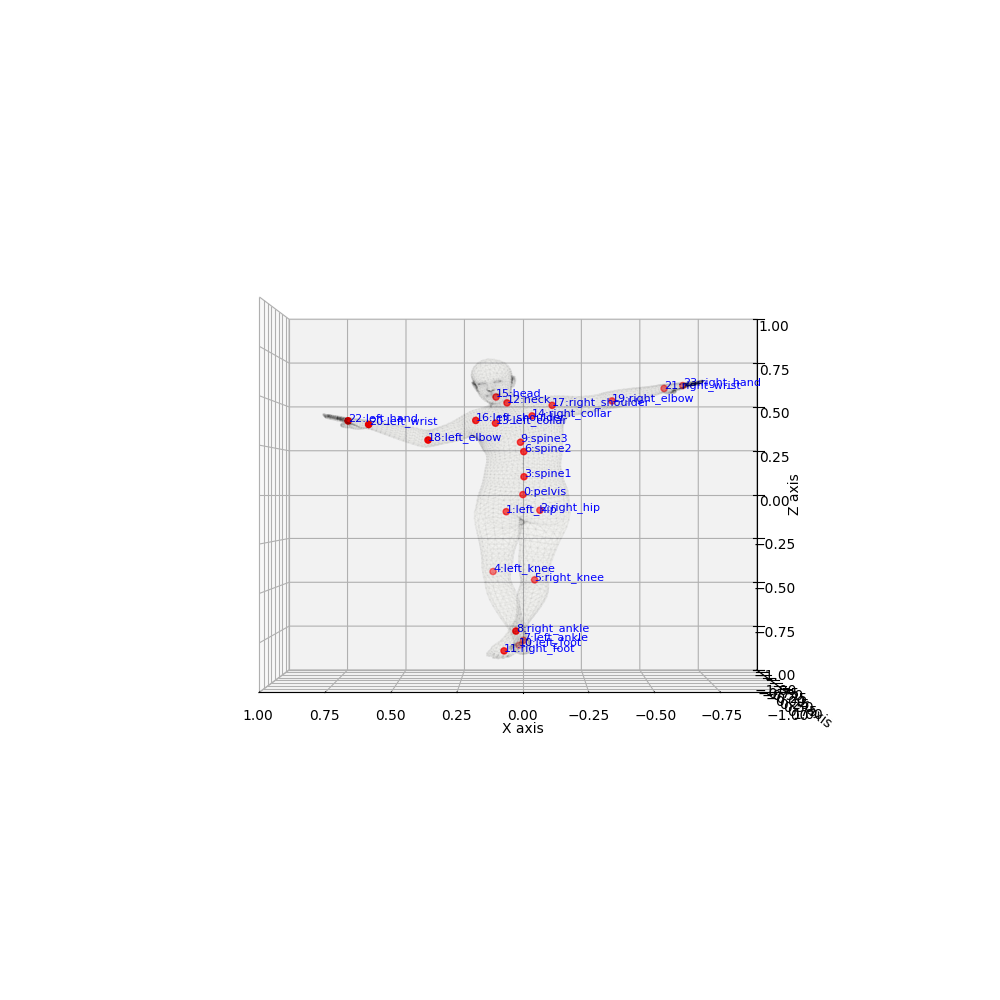

In [315]:
curr_frame = 0
smpl_joint_frame = smpl_joints[curr_frame]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# ax.view_init(elev=0)
ax.scatter(smpl_joint_frame[:, 0], smpl_joint_frame[:, 1], smpl_joint_frame[:, 2], color="r")
# add the mesh
mesh = Poly3DCollection(smpl_vertices[0][smpl_model.faces], alpha=0.01)
face_color = (1.0, 1.0, 0.9)
edge_color = (0, 0, 0)
mesh.set_edgecolor(edge_color)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim([-1.0, 1.0])
ax.set_ylim([-1.0, 1.0])
ax.set_zlim([-1, 1])
# show xyz axis
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

joint_names = get_SMPL_skeleton_names()
for i, joint in enumerate(smpl_joint_frame):
    ax.text(
        joint[0],
        joint[1],
        joint[2],
        f"{i}:{joint_names[i]}",
        color="blue",
        fontsize=8,
    )
ax.view_init(elev=0, azim=90)
ax


In [316]:
# convert SMPL to Motorica Keypoint

# create a df for smpl joints
expanded_smpl_joint_names = expand_skeleton(get_SMPL_skeleton_names())
len(expanded_smpl_joint_names)
smpl_joints_df = pd.DataFrame(poses, columns=expanded_smpl_joint_names)
# get in motorica joint order
motorica_joint_names = expand_skeleton(smpl2motorica())


In [317]:
smpl_joints_df

,pelvis_Xrotation,pelvis_Yrotation,pelvis_Zrotation,left_hip_Xrotation,left_hip_Yrotation,left_hip_Zrotation,right_hip_Xrotation,right_hip_Yrotation,right_hip_Zrotation,spine1_Xrotation,...,left_wrist_Zrotation,right_wrist_Xrotation,right_wrist_Yrotation,right_wrist_Zrotation,left_hand_Xrotation,left_hand_Yrotation,left_hand_Zrotation,right_hand_Xrotation,right_hand_Yrotation,right_hand_Zrotation
0,-0.319628,0.063085,-0.106008,-0.217060,-0.016043,0.043417,0.096264,0.165341,0.190510,0.199882,...,0.001647,-0.005635,0.004284,-0.006971,0.003135,-0.000004,-0.001744,-0.002792,0.001260,0.006738
1,-0.223865,-0.041374,-0.130750,-0.207704,-0.017794,0.015144,0.039177,0.119901,0.184624,0.172258,...,0.001781,-0.003976,0.002656,-0.006943,0.003735,0.001517,-0.001363,-0.002965,-0.000971,0.005440
2,-0.221808,-0.407982,-0.142549,-0.436765,-0.057884,0.235471,-0.053546,0.140791,0.166829,0.190597,...,0.000576,-0.003016,0.001217,-0.009013,0.003893,0.003343,-0.000728,-0.003760,-0.002219,0.005807
3,-0.129016,-0.740540,-0.030502,-0.472963,-0.116365,0.262145,-0.161408,0.099331,0.038966,0.069340,...,-0.001532,-0.001696,-0.001589,-0.010933,0.003761,0.005387,0.001054,-0.005468,-0.004161,0.004127
4,0.070445,-0.764484,-0.061201,-0.001609,-0.019556,0.100476,-0.216827,0.078142,0.053753,-0.143575,...,-0.010514,-0.004716,-0.005162,-0.015475,0.002300,0.001720,0.008500,-0.007688,-0.002264,0.004250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.011718,0.670464,0.041608,0.046094,0.000229,-0.049752,-0.037793,0.044351,-0.118781,-0.179727,...,-0.003653,-0.003857,-0.005707,-0.012780,0.008470,-0.005275,0.005368,0.001789,-0.000577,0.009631
68,0.000260,0.618410,0.020881,-0.000708,-0.000854,0.001773,0.074751,0.004039,-0.029789,-0.179452,...,-0.005593,-0.004863,-0.004994,-0.013039,0.007637,-0.006791,0.006743,0.001537,0.001317,0.009520
69,-0.019211,0.645281,0.023967,-0.009579,-0.003932,0.026120,0.068549,0.005307,-0.017236,-0.179417,...,-0.006747,-0.005780,-0.004862,-0.013853,0.007703,-0.008072,0.007498,0.001896,0.002729,0.010459
70,-0.033555,0.644343,0.027606,-0.013792,-0.006816,0.036277,0.071486,0.005103,-0.001875,-0.178487,...,-0.007076,-0.005641,-0.004707,-0.013814,0.007960,-0.008353,0.007939,0.002451,0.002683,0.011031


In [318]:
# reorder the columns
keypoint_smpl_df = smpl_joints_df[motorica_joint_names]
# convert from radian to degree and keep the same order
keypoint_smpl_df = keypoint_smpl_df.apply(np.rad2deg)
# rename the columns to motorica joint names
keypoint_smpl_df.columns = expand_skeleton(get_motorica_skeleton_names())


In [319]:
# rotate the pelvis
pelvis = keypoint_smpl_df[['Hips_Xrotation', 'Hips_Yrotation', 'Hips_Zrotation']].values
pelvis_rot = R.from_euler('xyz', pelvis, degrees=True)
pelvis_rot_offset = R.from_euler('xyz', [0, 180, 0], degrees=True)
pelvis_rot = pelvis_rot_offset * pelvis_rot
pelvis_rot_euler = pelvis_rot.as_euler('xyz', degrees=True)
keypoint_smpl_df[['Hips_Xrotation', 'Hips_Yrotation', 'Hips_Zrotation']] = pelvis_rot_euler


In [320]:
# add root position
root_pos_df = pd.DataFrame(root_trans, columns=["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"])
# # shuffle Y and Z axis while keeping the same order
# root_pos_df = root_pos_df[["Hips_Xposition", "Hips_Zposition", "Hips_Yposition"]]
# root_pos_df.columns = ["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"]   
# # reverse the direction of Y axis
# root_pos_df["Hips_Zposition"] = -root_pos_df["Hips_Zposition"] 
# # force the starting the position to be zero
# root_pos_df = root_pos_df - root_pos_df.iloc[0]
# # minutes offset for z position
# z_offset = -0.7553
# root_pos_df["Hips_Yposition"] = root_pos_df["Hips_Yposition"] - z_offset
# concate the root position
new_df = pd.concat([root_pos_df, keypoint_smpl_df], axis=1)
# # Add a dummy starting frame which is all zero
# new_df = pd.concat([pd.DataFrame(np.zeros((1, new_df.shape[1]), dtype=np.float32), columns=new_df.columns), new_df], axis=0)
# new_df.head()

In [321]:

# convert to joint position
motorica_dummy_data.values = new_df
position_mocap = MocapParameterizer("position").fit_transform([motorica_dummy_data])[0]
position_df = position_mocap.values
position_df.head()

,Hips_Xposition,Hips_Yposition,Hips_Zposition,RightUpLeg_Xposition,RightUpLeg_Yposition,RightUpLeg_Zposition,RightLeg_Xposition,RightLeg_Yposition,RightLeg_Zposition,RightFoot_Xposition,...,LeftHandThumb3_Nub_Zposition,Neck_Xposition,Neck_Yposition,Neck_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition
0,0.000000,0.000000,0.000000,0.094354,0.008150,0.005678,0.061457,-0.338101,-0.075507,-0.029900,...,0.041755,-0.147247,0.524279,0.051029,-0.212508,0.648590,0.003351,-0.212508,0.648590,0.003351
1,-0.784120,2.186401,-2.480659,-0.690248,2.199624,-2.484485,-0.709494,1.848345,-2.546095,-0.761632,...,-2.517447,-0.921436,2.718299,-2.460890,-0.975802,2.846483,-2.511865,-0.975802,2.846483,-2.511865
2,2.029374,2.554733,-10.107644,2.114402,2.575303,-10.144364,2.102011,2.225605,-10.215928,2.212441,...,-10.181980,1.860465,3.073354,-10.124260,1.781388,3.186652,-10.178073,1.781388,3.186652,-10.178073
3,8.191704,7.011398,-13.909545,8.261448,7.021766,-13.973024,8.223134,6.675372,-14.051168,8.363227,...,-14.251714,8.019608,7.518082,-13.972248,7.924304,7.613289,-14.034204,7.924304,7.613289,-14.034204
4,13.495426,6.649460,-14.250716,13.564056,6.649034,-14.316223,13.518906,6.295190,-14.334086,13.530484,...,-14.858189,13.319131,7.106560,-14.454329,13.245085,7.181516,-14.558657,13.245085,7.181516,-14.558657


In [322]:
# # get left foot and right foot position
# foot_position = position_df[[ "LeftFoot_Zposition", "RightFoot_Zposition"]].iloc[0]
# avg_vertical_offset = np.mean(foot_position)
# avg_vertical_offset = -0.05469189744854054

In [323]:
# # apply this offset all joints' z position
# # position_df.values = position_df.values.loc[:, new_df.columns.str.contains('_Zposition')] += avg_vertical_offset
# # position_df.values
# position_df.loc[:, position_df.columns.str.contains('_Zposition')] -= avg_vertical_offset
# position_mocap.values = position_df

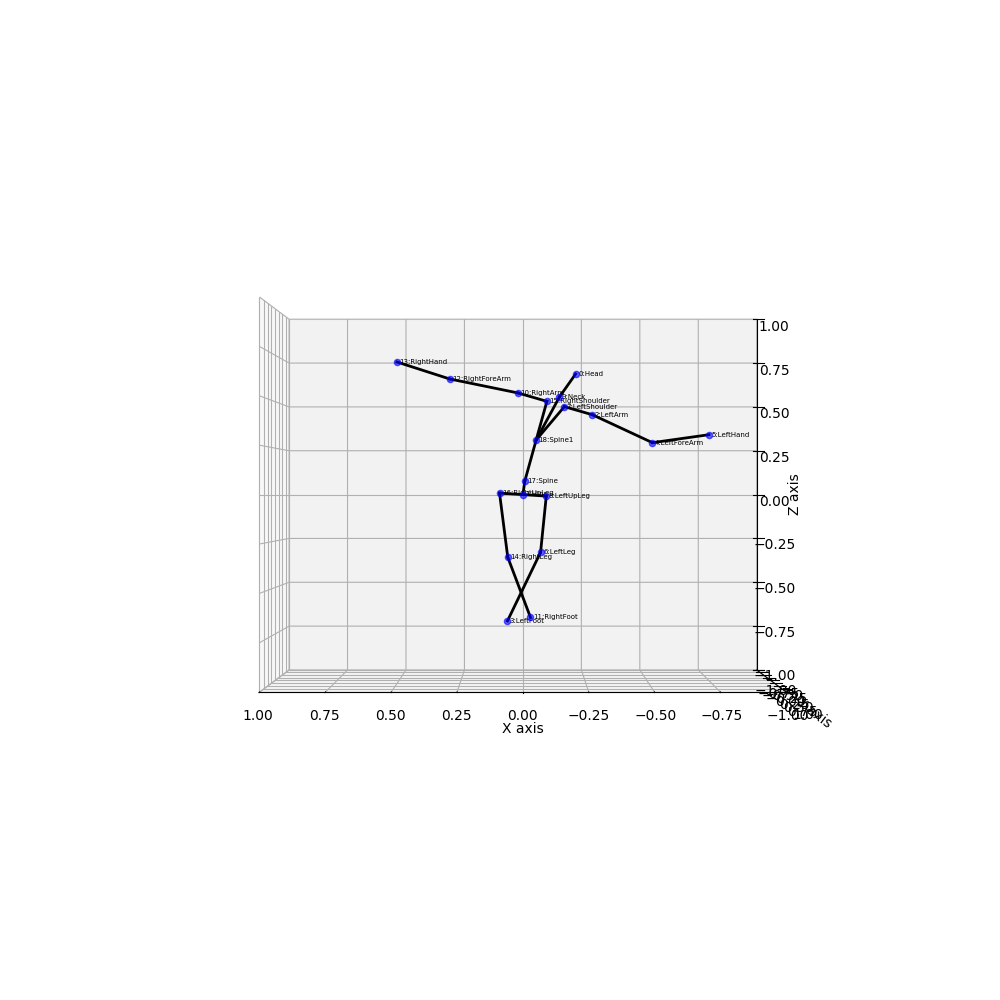

In [324]:
# visualize a frame
frame = 0
fig = plt.figure(figsize=(10, 10))
motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=position_mocap, frame=frame, joints=get_motorica_skeleton_names(), draw_names=True
        )
motorica_ax.set_xlabel('X axis')
motorica_ax.set_ylabel('Y axis')
motorica_ax.set_zlabel('Z axis')
motorica_ax.set_zlim([-1, 1])
motorica_ax.set_xlim([-1, 1])
motorica_ax.set_ylim([-1, 1])
motorica_ax.view_init(elev=0, azim=90)
plt.show()


In [325]:
# def save_video(df: pd.DataFrame):
#     import matplotlib.animation as animation
#     from IPython.display import HTML

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection="3d")
#     ax.set_zlim([-100, 100])
#     ax.set_xlim([-100, 100])
#     ax.set_ylim([-100, 100])
#     ax.view_init(elev=0, azim=120)

#     def update(frame):
#         ax.clear()
#         motorica_draw_stickfigure3d(
#             fig=fig,
#             mocap_track=df,
#             frame=frame,
#             joints=get_motorica_skeleton_names(),
#             draw_names=True,
#         )
#         ax.set_xlabel('X axis')
#         ax.set_ylabel('Y axis')
#         ax.set_zlabel('Z axis')
#         return ax

#     ani = animation.FuncAnimation(fig, update, frames=range(df.values.shape[0]))
#     ani.save("smpl2motorica.mp4", writer="ffmpeg", fps=30)
#     return ani
import cv2
import os
from tqdm import tqdm

def save_video(data):
    df = data.values
    image_folder = 'tmp'
    os.makedirs(image_folder, exist_ok=True)
    
    for frame in tqdm(range(len(df)), desc="Generating Videos"):
        fig = plt.figure(figsize=(10, 10))
        motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=data, frame=frame, joints=get_motorica_skeleton_names(), draw_names=True
        )
        motorica_ax.set_xlabel('X axis')
        motorica_ax.set_ylabel('Y axis')
        motorica_ax.set_zlabel('Z axis')
        motorica_ax.set_zlim([-1, 1])
        motorica_ax.set_xlim([-1, 1])
        motorica_ax.set_ylim([-1, 1])
        motorica_ax.view_init(elev=0, azim=90)
        motorica_ax.set_title(f"frame {frame}")
        plt.savefig(f"{image_folder}/frame_{frame:04d}.png")
        plt.close(fig)
    
    # compile the video
    video_name = 'smpl2motorica.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 12  # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    
    # remove the images and directory
    for image in images:
        os.remove(os.path.join(image_folder, image))
    os.rmdir(image_folder)
    
    return video_name

In [326]:
# save_video(position_mocap)